In [7]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import glob
from tqdm.auto import tqdm
import country_converter as coco
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

In [8]:
def load_and_join(files):
    df = pl.DataFrame()
    for i in tqdm(range(len(files))):
        if df.is_empty():
            df = pl.read_csv(files[i],columns=['initial-ip','saddr','classification']).unique(subset=['initial-ip'])
        else:
            tmp = pl.read_csv(files[i],columns=['initial-ip','saddr','classification']).unique(subset=['initial-ip'])
            df = df.join(tmp,on='initial-ip',how='left', suffix=f'_s{i}')
    return df

In [9]:
file1 = '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/bgp48_sra_checks/zmap_icmp_bgp_48_sra_1728075185.log.zst'

In [10]:
file2 = '/home/service/ipv6-measurements-mkoch/backup_2024/sra-analysis/data/ripe90-rescan/zmap_icmp_bgp_48_sra_1740416512.log.zst'

In [11]:
files = [file1,file2]

In [12]:
df = load_and_join(files)

  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
df

initial-ip,saddr,classification,saddr_s1,classification_s1
str,str,str,str,str
"""2a0d:1a43:f4d4::""","""2001:504:91::94""","""unreach_addr""",null,null
"""2804:5a4:147c::""","""2804:5a4:bac::cccc:6""","""timxceed""","""2804:5a4:bac::cccc:2""","""timxceed"""
"""2001:640:97fa::""","""2a02:290:2::3f:2""","""unreach_rejectroute""",null,null
"""2a0a:89c7:b48e::""","""2001:1a98:6677::9d9d:5445""","""unreach_rejectroute""",null,null
"""2a07:46:4bea::""","""2001:7f8:12:1::1:6186""","""unreach_noroute""","""2001:7f8:12:1::1:6186""","""unreach_noroute"""
…,…,…,…,…
"""2803:d460:b698::""","""2001:13b1:6000:39::1""","""unreach_addr""",null,null
"""2a13:ccc0:8ac8::""","""2a13:ccc0:ff01:1::1""","""unreach_noroute""",null,null
"""2a0e:840:7ef0::""","""2a02:1f0:1:2::2""","""unreach_rejectroute""",null,null


In [14]:
col = f"saddr_s1"
df = df.with_columns(
    pl.when(pl.col(col).is_null())
      .then(pl.lit("Not seen"))
      .when(pl.col(col) == pl.col("saddr"))
      .then(pl.lit("Unchanged"))
      .otherwise(pl.lit("Changed"))
      .alias(f"{col}_status")
)

In [15]:
df_long = df.unpivot(
    index=[],           # no id vars needed, just counts
    on='saddr_s1_status',
    variable_name="stage",
    value_name="status"
)

# Group by stage and status to get counts
df_plot = df_long.group_by(["stage", "status"]).agg(
    pl.len().alias("count")
).sort(["stage", "count"])

In [16]:
df_wide = df_plot.to_pandas().pivot(index='stage', columns='status', values='count')

df_pct = df_wide.div(df_wide.sum(axis=1), axis=0) * 100
df_pct = df_pct[['Unchanged','Not seen','Changed']]

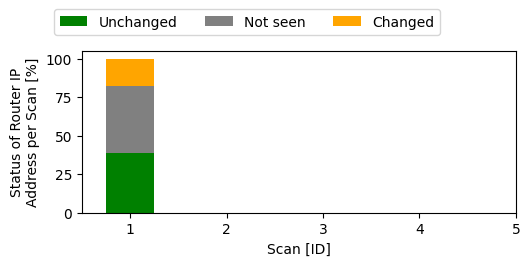

/home/service/artifacts-ipv6-sra-scanning/reports/figures/sra_stability_7month_apart_bgp48.png


In [17]:
figsize = (8*0.7,3*0.7)
fig,ax = vh.fig_ax(figsize)

df_pct.plot(
    kind='bar', 
    stacked=True,
    color=["green","gray","orange"],
    ax=ax)
ax.set_xlabel('Scan [ID]')
ax.set_ylabel('Status of Router IP\nAddress per Scan [%]')
ax.set_xticks([i for i in range(0,5)],[i for i in range(1,6)],rotation=0)
ax.set_yticks([0,25,50,75,100])
plt.legend(ncols=3,bbox_to_anchor=(-0.08,1.3),loc='upper left')
plt.show()
vh.save_plot(fig,'sra_stability_7month_apart_bgp48',autoclose=True)

In [18]:
df_pct

status,Unchanged,Not seen,Changed
stage,,,
saddr_s1_status,38.638666,43.429128,17.932205


In [19]:
df_wide

status,Changed,Not seen,Unchanged
stage,,,
saddr_s1_status,60480818,146475525,130318502
